In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/DFA2/processed.zip'  # Replace with your zip file path
extraction_path = '/content/' # Replace with the desired extraction path

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Zip file extracted to: {extraction_path}")

Zip file extracted to: /content/


In [ ]:
# 1. Setup & Imports
import os, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.cm as cm

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

BASE_DIR = r"/content/processed/mel"  # adjust if needed
TEST_DIR = r"/content/processed/mel/testing"
VAL_DIR   = r"/content/processed/mel/validating"
TRAIN_DIR  = r"/content/processed/mel/training"

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 50

BEST_MODEL_PATH = "best_resnet50_spectrogram.h5"
HEATMAP_DIR = "gradcam_outputs"
os.makedirs(HEATMAP_DIR, exist_ok=True)

In [ ]:
# 2. Data Loading & Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.08
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                              class_mode="binary", shuffle=True, seed=SEED)
val_gen = val_test_datagen.flow_from_directory(VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                              class_mode="binary", shuffle=False)
test_gen = val_test_datagen.flow_from_directory(TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                               class_mode="binary", shuffle=False)

Found 13956 images belonging to 2 classes.
Found 2826 images belonging to 2 classes.
Found 1088 images belonging to 2 classes.


In [ ]:
# Base: Pretrained ResNet50 backbone
# Load base ResNet50
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Option 1: freeze first 100 layers, fine-tune the rest
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True

# (then build your custom Conv2D + Dense head as before)

x = base_model.output  # feature maps

# --- Spectrogram-aware head ---
# 1. Conv to learn temporal-frequency patterns
x = layers.Conv2D(256, (3,3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Dropout(0.3)(x)

# 2. Temporal reduction
x = layers.Conv2D(128, (1,5), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(1,2))(x)
x = layers.Dropout(0.3)(x)

# 3. Frequency reduction
x = layers.Conv2D(128, (5,1), padding="same", activation="relu")(x)  # "same" avoids shrinking
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2,1))(x)
x = layers.Dropout(0.3)(x)


# 4. Global context pooling
x = layers.GlobalAveragePooling2D()(x)

# 5. Dense classifier with regularization
x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(base_model.input, outputs)

model.compile(
    optimizer=optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 28,755,329 (109.69 MB)

 Trainable params: 6,219,777 (23.73 MB)

 Non-trainable params: 22,535,552 (85.97 MB)

In [ ]:
# 4. Training with Callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(BEST_MODEL_PATH, monitor="val_loss", save_best_only=True, verbose=1)
]

history = model.fit(
    train_gen,
    epochs=250,
    validation_data=val_gen,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.5341 - auc: 0.5538 - loss: 1.0263
Epoch 1: val_loss improved from inf to 0.50424, saving model to best_resnet50_spectrogram.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 259s 269ms/step - accuracy: 0.5342 - auc: 0.5538 - loss: 1.0262 - val_accuracy: 0.8100 - val_auc: 0.9017 - val_loss: 0.5042 - learning_rate: 1.0000e-05
Epoch 2/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.6553 - auc: 0.7149 - loss: 0.7928
Epoch 2: val_loss improved from 0.50424 to 0.37588, saving model to best_resnet50_spectrogram.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 213s 244ms/step - accuracy: 0.6553 - auc: 0.7149 - loss: 0.7927 - val_accuracy: 0.8811 - val_auc: 0.9566 - val_loss: 0.3759 - learning_rate: 1.0000e-05
Epoch 3/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.7435 - auc: 0.8258 - loss: 0.6219
Epoch 3: val_loss improved from 0.37588 to 0.28309, saving model to best_resnet50_spectrogram.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 218s 250ms/step - accuracy: 0.7435 - auc: 0.8258 - loss: 0.6218 - val_accuracy: 0.9225 - val_auc: 0.9796 - val_loss: 0.2831 - learning_rate: 1.0000e-05
Epoch 4/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8065 - auc: 0.8904 - loss: 0.4976
Epoch 4: val_loss improved from 0.28309 to 0.22054, saving model to best_resnet50_spectrogram.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 217s 249ms/step - accuracy: 0.8065 - auc: 0.8904 - loss: 0.4976 - val_accuracy: 0.9444 - val_auc: 0.9905 - val_loss: 0.2205 - learning_rate: 1.0000e-05
Epoch 5/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8511 - auc: 0.9276 - loss: 0.4141
Epoch 5: val_loss improved from 0.22054 to 0.18939, saving model to best_resnet50_spectrogram.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 213s 244ms/step - accuracy: 0.8512 - auc: 0.9276 - loss: 0.4141 - val_accuracy: 0.9519 - val_auc: 0.9947 - val_loss: 0.1894 - learning_rate: 1.0000e-05
Epoch 6/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.8780 - auc: 0.9456 - loss: 0.3696
Epoch 6: val_loss improved from 0.18939 to 0.16626, saving model to best_resnet50_spectrogram.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 213s 244ms/step - accuracy: 0.8780 - auc: 0.9457 - loss: 0.3695 - val_accuracy: 0.9625 - val_auc: 0.9965 - val_loss: 0.1663 - learning_rate: 1.0000e-05
Epoch 7/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9026 - auc: 0.9638 - loss: 0.3062
Epoch 7: val_loss improved from 0.16626 to 0.13337, saving model to best_resnet50_spectrogram.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 263s 245ms/step - accuracy: 0.9026 - auc: 0.9638 - loss: 0.3062 - val_accuracy: 0.9745 - val_auc: 0.9974 - val_loss: 0.1334 - learning_rate: 1.0000e-05
Epoch 8/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9237 - auc: 0.9773 - loss: 0.2493
Epoch 8: val_loss improved from 0.13337 to 0.11395, saving model to best_resnet50_spectrogram.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 218s 250ms/step - accuracy: 0.9237 - auc: 0.9773 - loss: 0.2493 - val_accuracy: 0.9809 - val_auc: 0.9981 - val_loss: 0.1140 - learning_rate: 1.0000e-05
Epoch 9/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9343 - auc: 0.9811 - loss: 0.2297
Epoch 9: val_loss improved from 0.11395 to 0.11005, saving model to best_resnet50_spectrogram.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 256s 243ms/step - accuracy: 0.9343 - auc: 0.9811 - loss: 0.2297 - val_accuracy: 0.9834 - val_auc: 0.9981 - val_loss: 0.1100 - learning_rate: 1.0000e-05
Epoch 10/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9335 - auc: 0.9809 - loss: 0.2337
Epoch 10: val_loss improved from 0.11005 to 0.10899, saving model to best_resnet50_spectrogram.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 214s 245ms/step - accuracy: 0.9335 - auc: 0.9809 - loss: 0.2337 - val_accuracy: 0.9816 - val_auc: 0.9987 - val_loss: 0.1090 - learning_rate: 1.0000e-05
Epoch 11/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9463 - auc: 0.9874 - loss: 0.1938
Epoch 11: val_loss improved from 0.10899 to 0.09926, saving model to best_resnet50_spectrogram.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 213s 244ms/step - accuracy: 0.9463 - auc: 0.9874 - loss: 0.1938 - val_accuracy: 0.9876 - val_auc: 0.9980 - val_loss: 0.0993 - learning_rate: 1.0000e-05
Epoch 12/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9454 - auc: 0.9859 - loss: 0.2033
Epoch 12: val_loss improved from 0.09926 to 0.09747, saving model to best_resnet50_spectrogram.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 215s 247ms/step - accuracy: 0.9454 - auc: 0.9859 - loss: 0.2033 - val_accuracy: 0.9869 - val_auc: 0.9985 - val_loss: 0.0975 - learning_rate: 1.0000e-05
Epoch 13/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9475 - auc: 0.9868 - loss: 0.1985
Epoch 13: val_loss improved from 0.09747 to 0.09157, saving model to best_resnet50_spectrogram.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 216s 247ms/step - accuracy: 0.9475 - auc: 0.9868 - loss: 0.1985 - val_accuracy: 0.9883 - val_auc: 0.9985 - val_loss: 0.0916 - learning_rate: 1.0000e-05
Epoch 14/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9473 - auc: 0.9866 - loss: 0.1986
Epoch 14: val_loss did not improve from 0.09157
873/873 ━━━━━━━━━━━━━━━━━━━━ 215s 246ms/step - accuracy: 0.9473 - auc: 0.9866 - loss: 0.1985 - val_accuracy: 0.9869 - val_auc: 0.9982 - val_loss: 0.0969 - learning_rate: 1.0000e-05
Epoch 15/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9539 - auc: 0.9898 - loss: 0.1811
Epoch 15: val_loss did not improve from 0.09157
873/873 ━━━━━━━━━━━━━━━━━━━━ 214s 245ms/step - accuracy: 0.9539 - auc: 0.9898 - loss: 0.1811 - val_accuracy: 0.9844 - val_auc: 0.9982 - val_loss: 0.1050 - learning_rate: 1.0000e-05
Epoch 16/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9577 - auc: 0.9901 - loss: 0.1739
Epoch 16: val_loss improved from 0.09157 to 0.086

873/873 ━━━━━━━━━━━━━━━━━━━━ 217s 248ms/step - accuracy: 0.9577 - auc: 0.9901 - loss: 0.1739 - val_accuracy: 0.9901 - val_auc: 0.9991 - val_loss: 0.0861 - learning_rate: 1.0000e-05
Epoch 17/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9590 - auc: 0.9936 - loss: 0.1547
Epoch 17: val_loss did not improve from 0.08607
873/873 ━━━━━━━━━━━━━━━━━━━━ 216s 247ms/step - accuracy: 0.9590 - auc: 0.9936 - loss: 0.1547 - val_accuracy: 0.9858 - val_auc: 0.9992 - val_loss: 0.0959 - learning_rate: 1.0000e-05
Epoch 18/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9649 - auc: 0.9929 - loss: 0.1565
Epoch 18: val_loss did not improve from 0.08607
873/873 ━━━━━━━━━━━━━━━━━━━━ 213s 243ms/step - accuracy: 0.9649 - auc: 0.9929 - loss: 0.1565 - val_accuracy: 0.9880 - val_auc: 0.9992 - val_loss: 0.0876 - learning_rate: 1.0000e-05
Epoch 19/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9573 - auc: 0.9912 - loss: 0.1720
Epoch 19: ReduceLROnPlateau reducing learning rat

873/873 ━━━━━━━━━━━━━━━━━━━━ 212s 243ms/step - accuracy: 0.9661 - auc: 0.9939 - loss: 0.1462 - val_accuracy: 0.9876 - val_auc: 0.9996 - val_loss: 0.0845 - learning_rate: 5.0000e-06
Epoch 23/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9673 - auc: 0.9939 - loss: 0.1443
Epoch 23: val_loss improved from 0.08453 to 0.08283, saving model to best_resnet50_spectrogram.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 215s 247ms/step - accuracy: 0.9673 - auc: 0.9939 - loss: 0.1443 - val_accuracy: 0.9908 - val_auc: 0.9992 - val_loss: 0.0828 - learning_rate: 5.0000e-06
Epoch 24/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9693 - auc: 0.9953 - loss: 0.1355
Epoch 24: val_loss improved from 0.08283 to 0.07821, saving model to best_resnet50_spectrogram.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 215s 247ms/step - accuracy: 0.9693 - auc: 0.9953 - loss: 0.1355 - val_accuracy: 0.9926 - val_auc: 0.9995 - val_loss: 0.0782 - learning_rate: 5.0000e-06
Epoch 25/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9684 - auc: 0.9945 - loss: 0.1412
Epoch 25: val_loss did not improve from 0.07821
873/873 ━━━━━━━━━━━━━━━━━━━━ 227s 260ms/step - accuracy: 0.9684 - auc: 0.9945 - loss: 0.1413 - val_accuracy: 0.9912 - val_auc: 0.9996 - val_loss: 0.0784 - learning_rate: 5.0000e-06
Epoch 26/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9686 - auc: 0.9949 - loss: 0.1369
Epoch 26: val_loss improved from 0.07821 to 0.07792, saving model to best_resnet50_spectrogram.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 233s 267ms/step - accuracy: 0.9686 - auc: 0.9949 - loss: 0.1369 - val_accuracy: 0.9922 - val_auc: 0.9995 - val_loss: 0.0779 - learning_rate: 5.0000e-06
Epoch 27/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9720 - auc: 0.9944 - loss: 0.1368
Epoch 27: val_loss improved from 0.07792 to 0.07560, saving model to best_resnet50_spectrogram.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 224s 257ms/step - accuracy: 0.9720 - auc: 0.9944 - loss: 0.1368 - val_accuracy: 0.9940 - val_auc: 0.9992 - val_loss: 0.0756 - learning_rate: 5.0000e-06
Epoch 28/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9710 - auc: 0.9955 - loss: 0.1320
Epoch 28: val_loss did not improve from 0.07560
873/873 ━━━━━━━━━━━━━━━━━━━━ 215s 246ms/step - accuracy: 0.9710 - auc: 0.9955 - loss: 0.1320 - val_accuracy: 0.9908 - val_auc: 0.9993 - val_loss: 0.0781 - learning_rate: 5.0000e-06
Epoch 29/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9691 - auc: 0.9945 - loss: 0.1421
Epoch 29: val_loss did not improve from 0.07560
873/873 ━━━━━━━━━━━━━━━━━━━━ 213s 243ms/step - accuracy: 0.9691 - auc: 0.9945 - loss: 0.1421 - val_accuracy: 0.9904 - val_auc: 0.9994 - val_loss: 0.0804 - learning_rate: 5.0000e-06
Epoch 30/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9707 - auc: 0.9960 - loss: 0.1259
Epoch 30: ReduceLROnPlateau reducing learning rat

873/873 ━━━━━━━━━━━━━━━━━━━━ 219s 250ms/step - accuracy: 0.9789 - auc: 0.9969 - loss: 0.1147 - val_accuracy: 0.9929 - val_auc: 0.9997 - val_loss: 0.0733 - learning_rate: 1.5625e-07
Epoch 45/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9698 - auc: 0.9952 - loss: 0.1368
Epoch 45: val_loss did not improve from 0.07332
873/873 ━━━━━━━━━━━━━━━━━━━━ 214s 245ms/step - accuracy: 0.9698 - auc: 0.9952 - loss: 0.1368 - val_accuracy: 0.9915 - val_auc: 0.9998 - val_loss: 0.0763 - learning_rate: 1.5625e-07
Epoch 46/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9759 - auc: 0.9970 - loss: 0.1176
Epoch 46: val_loss did not improve from 0.07332
873/873 ━━━━━━━━━━━━━━━━━━━━ 215s 246ms/step - accuracy: 0.9759 - auc: 0.9970 - loss: 0.1176 - val_accuracy: 0.9926 - val_auc: 0.9997 - val_loss: 0.0742 - learning_rate: 1.5625e-07
Epoch 47/250
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9766 - auc: 0.9970 - loss: 0.1196
Epoch 47: ReduceLROnPlateau reducing learning rat

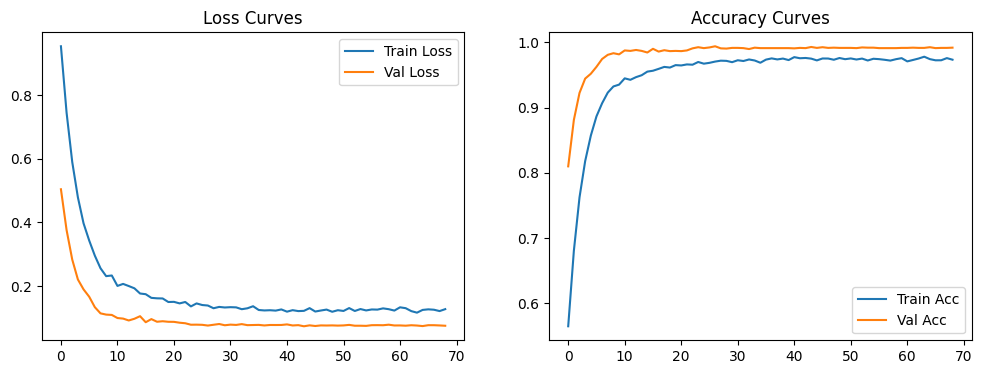

In [ ]:
# Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss Curves')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy Curves')
plt.show()

68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step
              precision    recall  f1-score   support

        fake       0.97      0.66      0.79       544
        real       0.74      0.98      0.85       544

    accuracy                           0.82      1088
   macro avg       0.86      0.82      0.82      1088
weighted avg       0.86      0.82      0.82      1088

Confusion Matrix:
 [[361 183]
 [ 11 533]]
ROC-AUC: 0.963647545415225


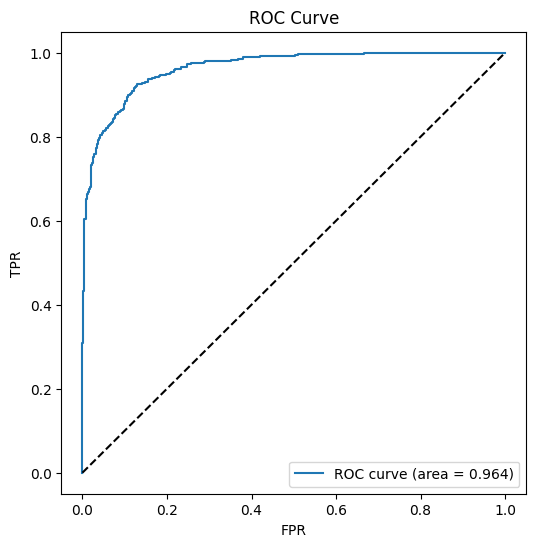

In [ ]:
# 5. Evaluation
model = load_model(BEST_MODEL_PATH)

test_gen.reset()
y_prob = model.predict(test_gen)
y_pred = (y_prob.ravel() >= 0.5).astype(int)
y_true = test_gen.classes

print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("ROC-AUC:", roc_auc_score(y_true, y_prob))

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_score, recall_score, f1_score, precision_recall_curve,
    RocCurveDisplay, PrecisionRecallDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, test_gen, class_names=None):
    """
    Evaluate model on test set and calculate all important metrics:
    Accuracy, Precision, Recall, F1-score, Confusion Matrix, ROC-AUC, PR Curve.
    """

    # Evaluate with model.evaluate
    results = model.evaluate(test_gen, verbose=0)
    metrics_names = model.metrics_names
    results_dict = dict(zip(metrics_names, results))

    # Predictions
    y_pred_proba = model.predict(test_gen, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype("int32").flatten()
    y_true = test_gen.classes

    # Additional metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Print metrics
    print("==== Evaluation Metrics ====")
    for k, v in results_dict.items():
        print(f"{k}: {v:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}\n")

    # Classification Report
    if class_names is None:
        class_names = list(test_gen.class_indices.keys())
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                    estimator_name="EfficientNetB0").plot()
    plt.title("ROC Curve")
    plt.show()

    # Precision-Recall Curve
    prec, rec, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(rec, prec)

    PrecisionRecallDisplay(precision=prec, recall=rec).plot()
    plt.title(f"Precision-Recall Curve (AUC={pr_auc:.4f})")
    plt.show()

    return {
        "accuracy": results_dict.get("accuracy"),
        "auc": results_dict.get("auc"),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc
    }
model.load_weights("best_efficientnet_model.h5")
metrics = evaluate_model(model, test_gen, class_names=list(test_gen.class_indices.keys()))

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'best_efficientnet_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_channel = predictions[:, 0]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()



import cv2

sample_path = test_gen.filepaths[0]
img = tf.keras.utils.load_img(sample_path, target_size=IMG_SIZE)
arr = tf.keras.utils.img_to_array(img)
arr = np.expand_dims(arr/255.0, axis=0)

last_conv_layer_name = [l.name for l in model.layers if "conv" in l.name][-1]
heatmap = make_gradcam_heatmap(arr, model, last_conv_layer_name)

# Overlay
heatmap_resized = cv2.resize(heatmap, (IMG_SIZE[1], IMG_SIZE[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

superimposed = heatmap_color * 0.4 + np.array(img)
plt.imshow(np.uint8(superimposed))
plt.axis("off")
plt.title("Grad-CAM")
plt.show()